<a href="https://colab.research.google.com/github/rll/deepul/blob/master/homeworks/hw2/hw2_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Getting Started

## Overview
This semester, all homeworks will be conducted through Google Colab notebooks. All code for the homework assignment will be written and run in this notebook. Running in Colab will automatically provide a GPU, but you may also run this notebook locally by following [these instructions](https://research.google.com/colaboratory/local-runtimes.html) if you wish to use your own GPU.

You will save images in the notebooks to use and fill out a given LaTeX template which will be submitted to Gradescope, along with your notebook code.

## Using Colab
On the left-hand side, you can click the different icons to see a Table of Contents of the assignment, as well as local files accessible through the notebook.

Make sure to go to **Runtime -> Change runtime type** and select **GPU** as the hardware accelerator. This allows you to use a GPU. Run the cells below to get started on the assignment. Note that a session is open for a maximum of 12 hours, and using too much GPU compute may result in restricted access for a short period of time. Please start the homework early so you have ample time to work.

**If you loaded this notebook from clicking "Open in Colab" from github, you will need to save it to your own Google Drive to keep your work.**

## General Tips
In each homework problem, you will implement an flow model and run it on one to two datasets. We provide the expected outputs to help as a sanity check.

Feel free to print whatever output (e.g. debugging code, training code, etc) you want, as the graded submission will be the submitted pdf with images.

After you complete the assignment, download all of the image outputted in the results/ folder and upload them to the figure folder in the given latex template.

Run the cells below to download and load up the starter code.

In [1]:
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False

if IN_COLAB:
    !if [ -d deepul ]; then rm -Rf deepul; fi
    !git clone -b magda https://github.com/mgswiss15/deepul.git 
    !unzip -qq deepul/homeworks/hw1/data/hw1_data.zip -d deepul/homeworks/hw1/data/
    !pip install ./deepul
else:
    %load_ext autoreload
    %autoreload 2
    import sys
    import pathlib
    cwd = pathlib.Path().absolute()
    sys.path.append(str(cwd.parents[0]))
    sys.path.append(str(cwd.parents[1]))
    print(sys.path)

['/home/magda/Github/deepul/homeworks/hw2', '/home/magda/anaconda3/envs/pytorch/lib/python38.zip', '/home/magda/anaconda3/envs/pytorch/lib/python3.8', '/home/magda/anaconda3/envs/pytorch/lib/python3.8/lib-dynload', '', '/home/magda/anaconda3/envs/pytorch/lib/python3.8/site-packages', '/home/magda/anaconda3/envs/pytorch/lib/python3.8/site-packages/IPython/extensions', '/home/magda/.ipython', '/home/magda/Github/deepul/homeworks', '/home/magda/Github/deepul']


In [2]:
if IN_COLAB:
    from deepul.hw2_helper import *
else:
    from hw2_helper import *

# Question 3: RealNVP on Higher Dimensions


In this problem, you will train a flow model to invertibly map a high dimensional dataset of celebrity
faces to gaussian noise. The dataset is a low-resolution (32 × 32) version of the CelebA-HQ dataset that has been quantized to 2 bits per color channel.



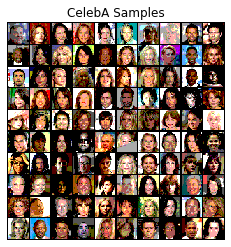

In [3]:
visualize_q3_data()

## Part (a): RealNVP [40pt]

Use the affine coupling flow from RealNVP and a form of [data-dependent initialization](https://arxiv.org/abs/1602.07868) that normalizes activations from an initial forward pass with a minibatch.
We describe a reference architecture below that can achieve good performance, but you are free
and encouraged to use different architectures and/or structure your code differently.



```
Preprocess() # dequantization, logit trick from RealNVP (Dinh et al) Section 4.1

for _ in range(4):
  AffineCouplingWithCheckerboard() # Figure 3 in Dinh et al - (left)
  ActNorm() # described in Glow (Kingma & Dhariwal) Section 3.1
Squeeze(), # [b, c, h, w] --> [b, c*4, h//2, w//2]

for _ in range(3):
  AffineCouplingWithChannel()
  ActNorm()
Unsqueeze(), # [b, c*4, h//2, w//2] --> [b, c, h, w]

for _ in range(3):
  AffineCouplingWithCheckerboard()
  ActNorm()
```



Here, we provide pseudocode for the basic structure of each coupling layer. 



```
# pseudocode
ResnetBlock: n_filters
  h = x
  h = conv2d(n_filters, n_filters, (1,1), stride=1, padding=0)(h)
  h = relu(h)
  h = conv2d(n_filters, n_filters, (3,3), stride=1, padding=1)(h)
  h = relu(h)
  h = conv2d(n_filters, n_filters, (1,1), stride=1, padding=0)(h)
  return h + x

SimpleResnet: n_filters = 128, n_blocks = 8, n_out
  conv2d(in_channels, n_filters=n_filters, (3,3), stride=1, padding=1)
  apply 8 ResnetBlocks with n_filters=n_filters
  relu()
  conv2d(in_channels=n_filters, out_channels=n_out, (3,3), stride=1, padding=1)
  
AffineCoupling(x, mask):
  x_ = x * mask
  log_s, t = torch.chunk(SimpleResnet(x_), 2, dim=1)
  # calculate log_scale, as done in Q1(b)
  t = t * (1.0 - mask)
  log_scale = log_scale * (1.0 - mask)
  z = x * torch.exp(log_scale) + t
  log_det_jacobian = log_scale
  return z, log_det_jacobian
```



We use an Adam Optimizer with a warmup over 200 steps till a learning rate of 5e-4. We didn’t decay the learning rate but it is a generally recommended practice while training generative models. We show samples from our model at the end of training, as well as interpolations between several images in our dataset.  Our reference solution achieves a test loss of about 0.55 bits/dim after 100 epochs. 



**You will provide these deliverables**


1.   Over the course of training, record the average negative log-likelihood (nats / dim) of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves. 
2.   Report the final test set performance of your final model
3. 100 samples from the final trained model
4. 5 rows of interpolations between images in the test set; each row consists of the start and end images, and 4 intermediate ones. You should return 30 total images. 



### Solution
Fill out the function below and return the necessary arguments. Feel free to create more cells if need be.

In [4]:
from deepul.hw2_Q3utils import *

### Results

Once you've implemented `q3_a`, execute the cells below to visualize and save your results



First eval
Training loop
Epoch 0 loss train: 4287023546368.0, test: 3402120003584.0
Begin sampling
Done sampling
Begin interpolate
original x tensor(1., device='cuda:0') tensor(0., device='cuda:0')
Reconstructed x tensor(5.2599, device='cuda:0') tensor(-6.9124, device='cuda:0')
Final Test Loss: 1107460940.0530


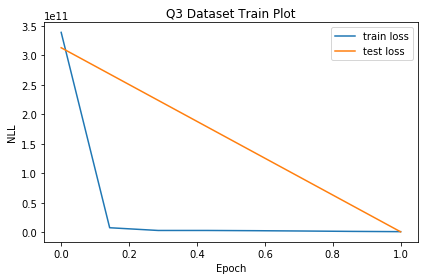

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


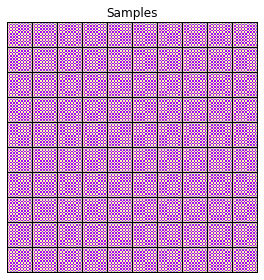

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


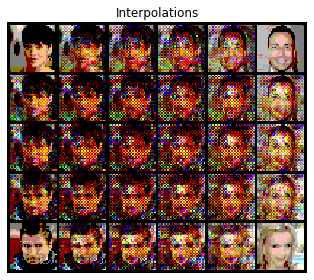

In [5]:
q3_save_results(q3_a, 'a')